# Inicio

In [2]:
import pandas as pd
import numpy as np
import re
import os
import json
import boto3
from datetime import date
from matplotlib import pyplot as plt
import pickle

import warnings
warnings.filterwarnings("ignore")

# Importar archivo

In [3]:
yellow_df = pd.read_csv("yellow_trips_day.csv")
yellow_df.head()

,Unnamed: 0,barrio_abordaje,barrio_destino,dia,cant_registros,sum_total,sum_distancia,prom_total
0,0,Bronx,Bronx,2022-01-01,42,743.61,76.04,17.705000
1,1,Bronx,Bronx,2022-01-02,36,662.98,58.43,18.416111
2,2,Bronx,Bronx,2022-01-03,48,816.77,87.81,17.016042
3,3,Bronx,Bronx,2022-01-04,56,1335.13,112.60,23.841607
4,4,Bronx,Bronx,2022-01-05,50,1145.12,127.19,22.902400


<p>Se eliminan las columnas no utilizadas y los registros con valores no utilizados (aquellos en donde "barrio_abordaje" tiene un valor diferente a los 5 barrios a estudiar)

In [4]:
yellow_df.drop(columns=["Unnamed: 0", "barrio_destino"], inplace=True)
mask = yellow_df["barrio_abordaje"].apply(lambda x: x not in ["Unknown", "EWR"])
yellow_df.dia = pd.to_datetime(yellow_df.dia).dt.date
yellow_df = yellow_df[mask]
yellow_df = yellow_df[yellow_df.dia < date(year=2024, month=3, day=1)]
yellow_df.head()

,barrio_abordaje,dia,cant_registros,sum_total,sum_distancia,prom_total
0,Bronx,2022-01-01,42,743.61,76.04,17.705000
1,Bronx,2022-01-02,36,662.98,58.43,18.416111
2,Bronx,2022-01-03,48,816.77,87.81,17.016042
3,Bronx,2022-01-04,56,1335.13,112.60,23.841607
4,Bronx,2022-01-05,50,1145.12,127.19,22.902400


In [40]:
yellow_df.describe()

,cant_registros,sum_total,sum_distancia,prom_total
count,23117.000000,2.311700e+04,23117.000000,23117.000000
mean,3571.566726,8.932533e+04,12074.289287,60.526750
std,16127.465487,3.158913e+05,34710.669968,34.321102
min,1.000000,0.000000e+00,0.000000,0.000000
25%,5.000000,3.832600e+02,67.300000,34.579634
50%,48.000000,2.067470e+03,308.590000,55.180000
75%,355.000000,1.720878e+04,3499.630000,78.237000
max,121943.000000,2.895222e+06,233309.090000,195.150000


# Entrenamiento de modelo para taxis amarillos

<p>Para el modelo, se plantea utilizar la librería skforecast, que permite adaptar modelos de regresión de Scikit-Learn, redes neuronales y otros, a datos en series temporales. Esta adaptación es necesaria porque en estas series de datos, los valores de un momento determinado son dependientes de los valores de la variable de estudio en momentos anteriores (lags). Esta librería se escogió por las siguientes razones: </p>

- Permite realizar una optimización de parámetros basada en búsqueda por grid, sobre los parámetros del modelo planteado y sobre la cantidad de lags a considerar.
- Permite, como en este caso, entrenar el modelo con más de una serie de valores relacionados. Esto es útil dado que en algunos casos, la variable estudiada es influenciada no sólo por sus propios valores en el tiempo, sino también por los valores de otra u otras variables. Esta característica se aprovechará para estudiar las medidas estadísticas entre los diferentes barrios.
- Dado a que puede utilizar modelos que normalmente no responden adecuadamente a parámetros temporales complejos, aprovecha las ventajas de los mismos en series temporales. En este caso, se escogió el modelo RandomForest por su robustez y versatilidad, al poder entrenar varios subconjuntos de columnas para elegir la mejor adaptación posible.

In [5]:
import sklearn as skl
import skforecast as skf
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries, backtesting_forecaster_multiseries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Creación de tabla pivote, autocorrelación y autocorrelación parcial

<p>Para el entrenamiento de los modelos, se realizará una tabla pivote, que tendrá como columnas las diferentes medidas a estudiar (cantidad de registros, suma de distancia, suma de costo total, promedio de costo total) para cada uno de los barrios (Bronx, Brooklyn, Manhattan, Queens, Staten Island), y los índices serán los días. En el caso de las columnas de promedio de total, se realizará el cálculo sobre los valores de las columnas de suma de total y cantidad.

In [6]:
yellow_df_pivot = yellow_df.pivot_table(index="dia", columns="barrio_abordaje", values=["cant_registros", "sum_distancia", "sum_total"], fill_value=0, aggfunc="sum")
yellow_df_pivot.columns = ["cant_registros_bronx", "cant_registros_brooklyn", "cant_registros_manhattan", "cant_registros_queens", "cant_registros_island",\
                            "sum_distancia_bronx", "sum_distancia_brooklyn", "sum_distancia_manhattan", "sum_distancia_queens", "sum_distancia_island",\
                            "sum_total_bronx", "sum_total_brooklyn", "sum_total_manhattan", "sum_total_queens", "sum_total_island"]
for col in ["bronx", "brooklyn", "manhattan", "queens", "island"]:
    yellow_df_pivot[f"prom_total_{col}"] = yellow_df_pivot[f"sum_total_{col}"]/yellow_df_pivot[f"cant_registros_{col}"]
    yellow_df_pivot[f"prom_total_{col}"].fillna(0, inplace=True)
    yellow_df_pivot[f"cant_registros_{col}"] = yellow_df_pivot[f"cant_registros_{col}"].astype("float64")
yellow_df_pivot

,cant_registros_bronx,cant_registros_brooklyn,cant_registros_manhattan,cant_registros_queens,cant_registros_island,sum_distancia_bronx,sum_distancia_brooklyn,sum_distancia_manhattan,sum_distancia_queens,sum_distancia_island,sum_total_bronx,sum_total_brooklyn,sum_total_manhattan,sum_total_queens,sum_total_island,prom_total_bronx,prom_total_brooklyn,prom_total_manhattan,prom_total_queens,prom_total_island
dia,,,,,,,,,,,,,,,,,,,,
2022-01-01,93.0,729.0,55318.0,6091.0,1.0,272.33,3462.88,152704.99,76119.02,17.10,2369.39,20059.78,962794.50,299496.76,74.55,25.477312,27.516845,17.404724,49.170376,74.550000
2022-01-02,80.0,295.0,47937.0,8754.0,3.0,177.79,1470.09,131711.40,109320.48,32.90,2487.76,8395.95,827271.19,435467.55,184.85,31.097000,28.460847,17.257467,49.744979,61.616667
2022-01-03,112.0,383.0,60624.0,9811.0,7.0,446.23,1592.19,142096.95,117228.35,103.92,3596.13,10737.94,973480.01,469891.01,444.48,32.108304,28.036397,16.057667,47.894303,63.497143
2022-01-04,131.0,365.0,64645.0,8047.0,2.0,518.77,1577.71,148149.04,96331.02,19.53,4589.32,10597.94,1032795.72,383407.79,119.24,35.032977,29.035452,15.976421,47.646053,59.620000
2022-01-05,134.0,326.0,65927.0,6945.0,0.0,574.19,1439.51,150154.17,83532.96,0.00,4885.56,9700.83,1052707.24,332237.97,0.00,36.459403,29.757147,15.967771,47.838441,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25,270.0,1198.0,83530.0,9804.0,6.0,1515.78,6204.03,203595.60,118399.81,29.84,8106.64,38642.92,1863928.72,666166.93,147.74,30.024593,32.256194,22.314482,67.948483,24.623333
2024-02-26,303.0,987.0,73594.0,10660.0,4.0,2292.11,5730.12,168903.20,130120.72,3.87,11426.08,32237.66,1729081.18,753695.91,53.36,37.709835,32.662270,23.494866,70.703181,13.340000
2024-02-27,320.0,1265.0,106932.0,9245.0,2.0,2246.54,6921.15,228437.68,109510.30,0.30,11731.26,40963.68,2431053.53,633204.69,145.88,36.660187,32.382356,22.734575,68.491584,72.940000


In [41]:
yellow_df_pivot.describe()

,cant_registros_bronx,cant_registros_brooklyn,cant_registros_manhattan,cant_registros_queens,cant_registros_island,sum_distancia_bronx,sum_distancia_brooklyn,sum_distancia_manhattan,sum_distancia_queens,sum_distancia_island,sum_total_bronx,sum_total_brooklyn,sum_total_manhattan,sum_total_queens,sum_total_island,prom_total_bronx,prom_total_brooklyn,prom_total_manhattan,prom_total_queens,prom_total_island
count,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,7.900000e+02,7.900000e+02,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000
mean,165.164557,788.231646,94028.469620,9522.097468,7.312658,855.873835,3869.814000,232478.027392,116040.255266,74.188304,5543.919899,24628.086342,1.996119e+06,5.870762e+05,472.401823,33.344880,31.327547,21.260959,61.109250,61.726949
std,52.587962,231.862330,17176.883834,1872.099381,4.135502,366.529922,1173.792306,43811.853611,23345.391114,50.603013,1948.642072,7437.356947,4.594138e+05,1.588784e+05,272.649447,2.875086,3.083708,2.979140,9.151796,22.700376
min,8.000000,244.000000,3579.000000,110.000000,0.000000,36.390000,1194.270000,9772.340000,645.930000,0.000000,268.480000,8395.950000,1.036832e+05,4.474300e+03,0.000000,24.235789,24.402863,15.658468,38.153924,0.000000
25%,129.250000,643.000000,83651.000000,8499.750000,4.000000,594.060000,3169.905000,206700.380000,104309.455000,25.302500,4116.067500,20151.712500,1.698754e+06,4.929407e+05,236.617500,31.404429,28.703882,18.359450,51.696733,54.556000
50%,159.000000,758.500000,95944.000000,9791.000000,8.000000,797.840000,3715.690000,236662.645000,118449.415000,76.675000,5258.540000,23788.605000,2.001880e+06,5.690300e+05,516.325000,33.366860,31.319444,22.424042,66.617913,64.265500
75%,201.000000,908.500000,107037.250000,10768.500000,10.000000,1057.050000,4443.475000,262233.670000,131415.897500,112.500000,7019.745000,28140.045000,2.271826e+06,7.083382e+05,664.040000,35.403069,33.818260,23.827385,69.360960,73.434911
max,353.000000,1928.000000,131187.000000,15013.000000,21.000000,2410.040000,9331.230000,314645.360000,187936.310000,230.890000,12985.140000,77712.180000,3.464559e+06,1.044037e+06,1362.670000,44.085361,42.373053,28.969891,74.808185,150.360000


<p>Los modelos ACF y PACF permiten estudiar la influencia de la cantidad de lags sobre los valores en un momento dado (instante cero). En este caso, y según los gráficos, se entrenarán los modelos sobre los lags 5, 7, 8, 10, 14 y 15.

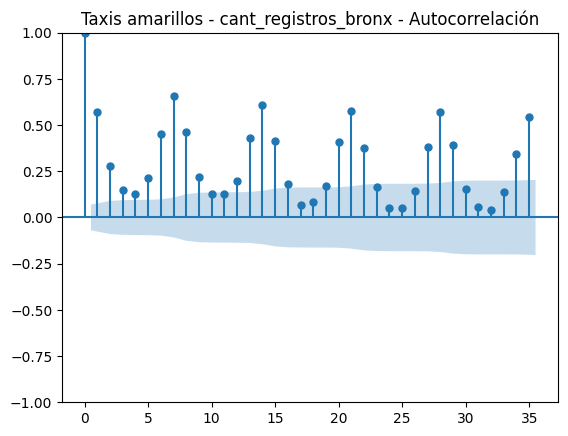

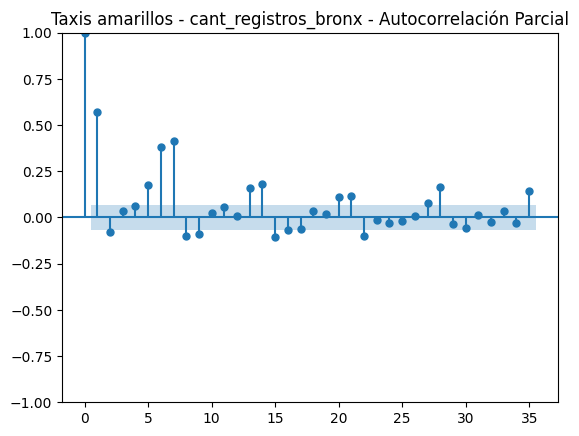

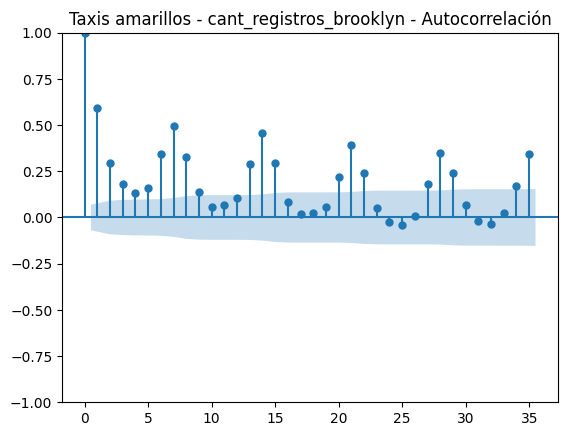

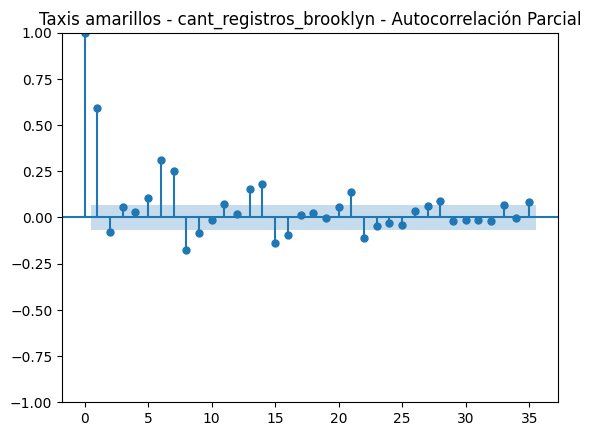

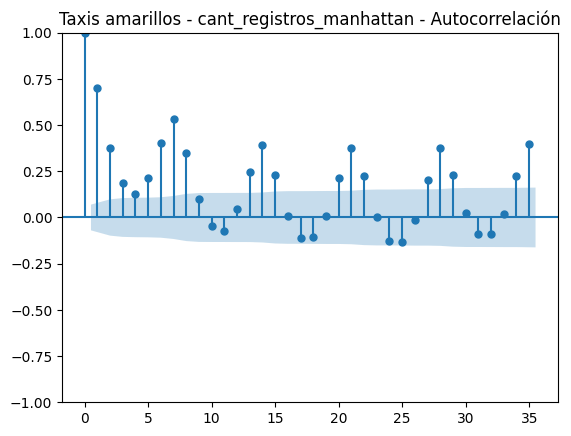

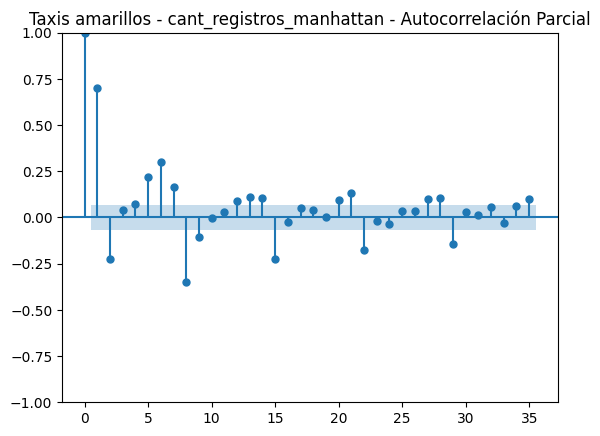

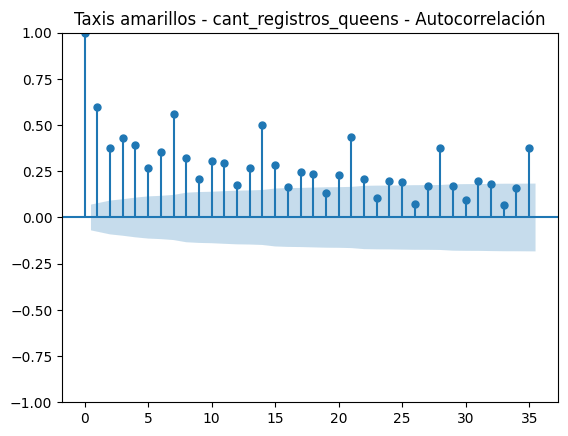

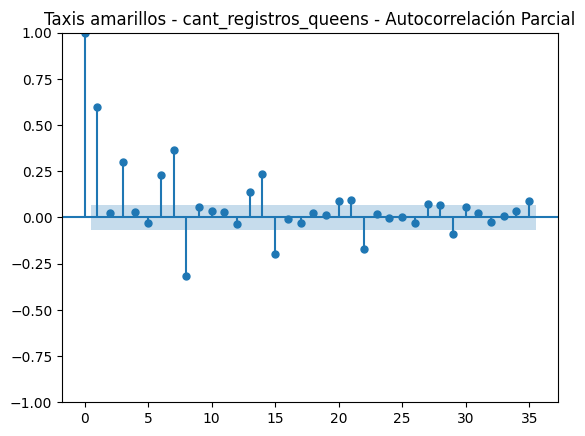

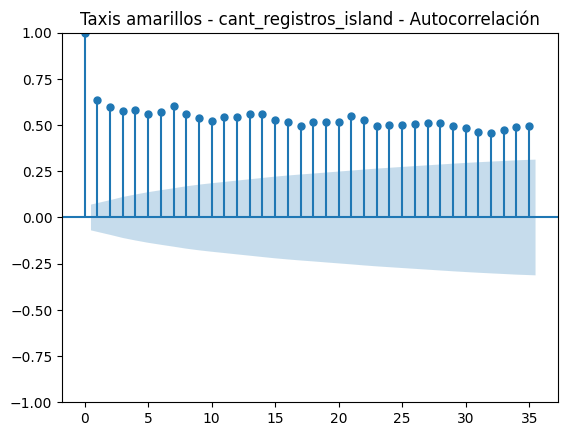

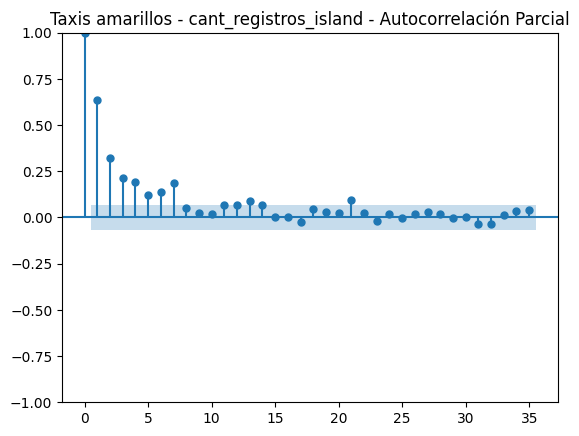

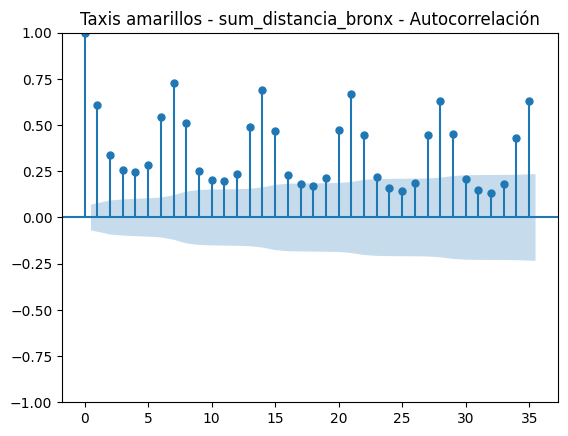

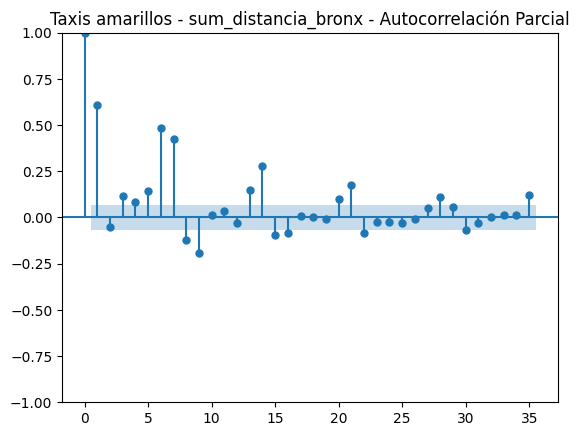

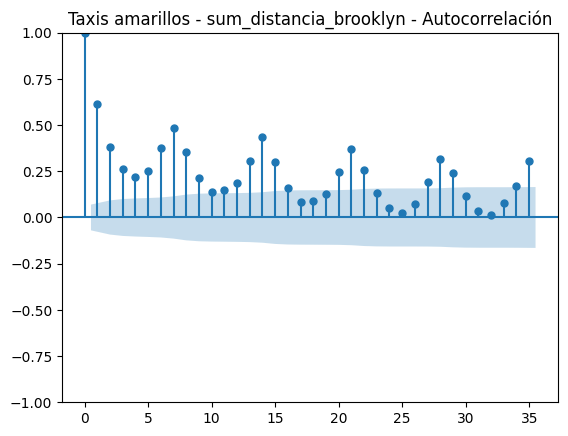

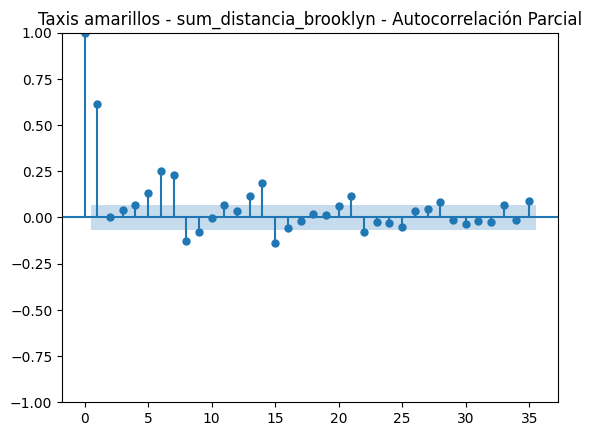

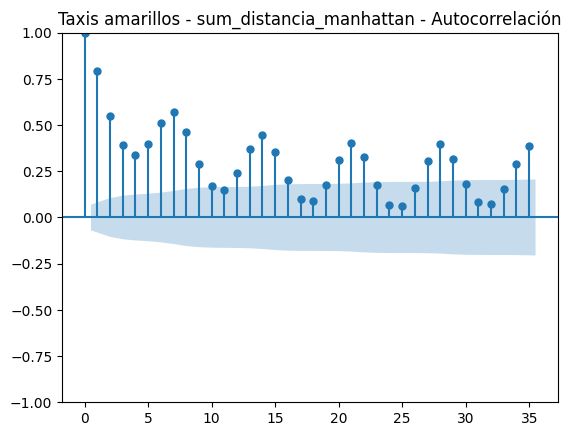

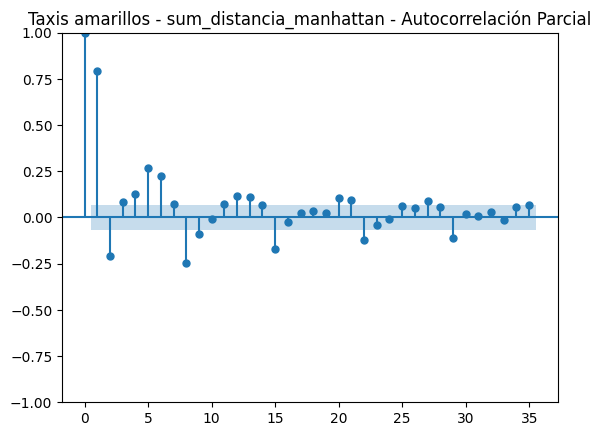

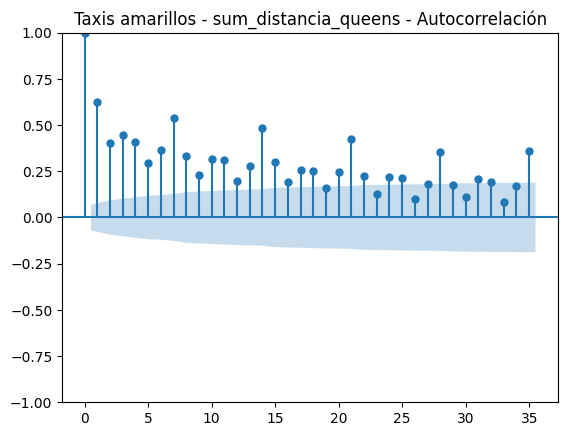

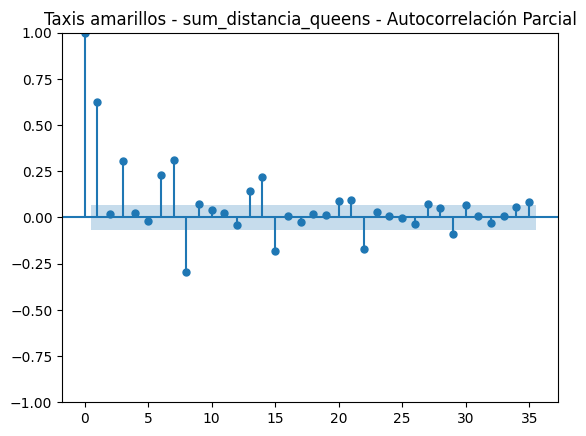

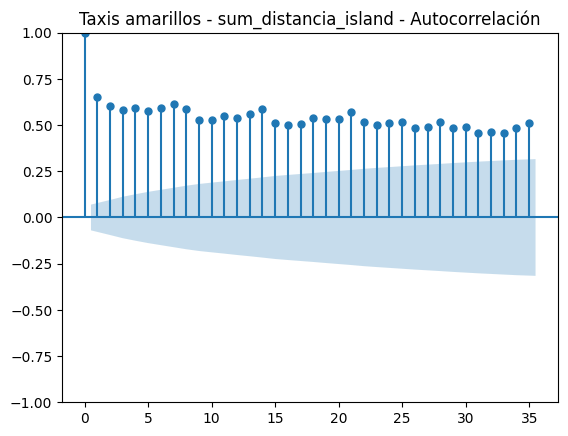

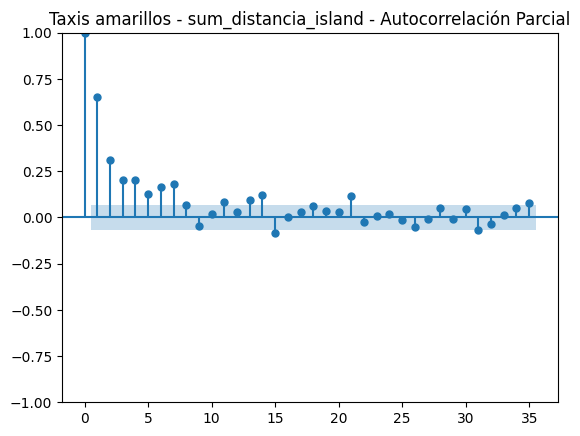

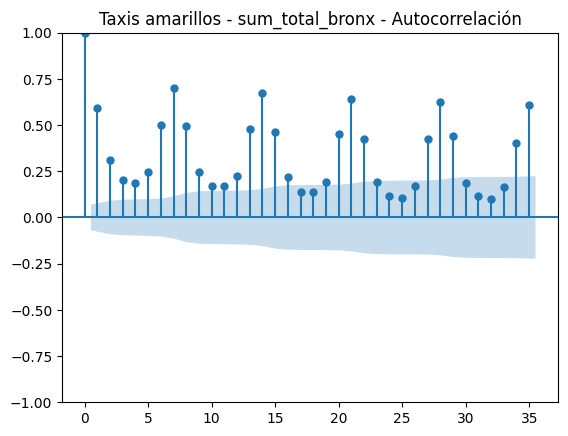

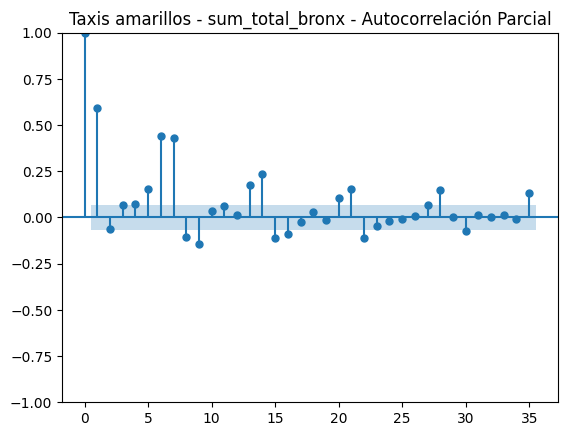

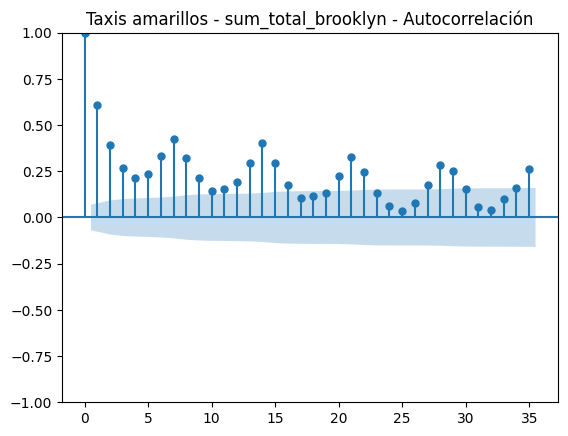

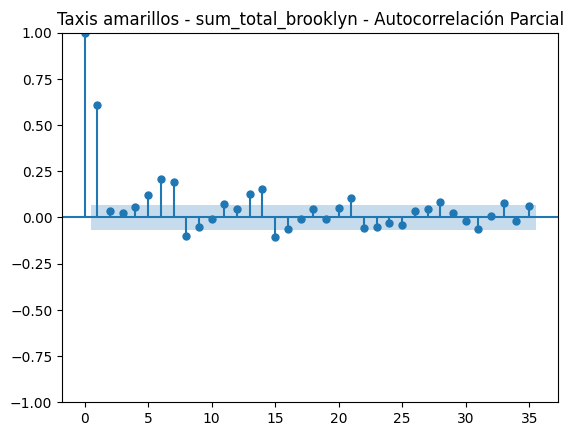

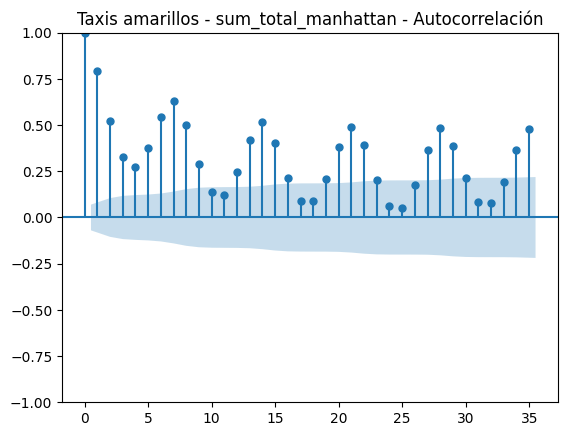

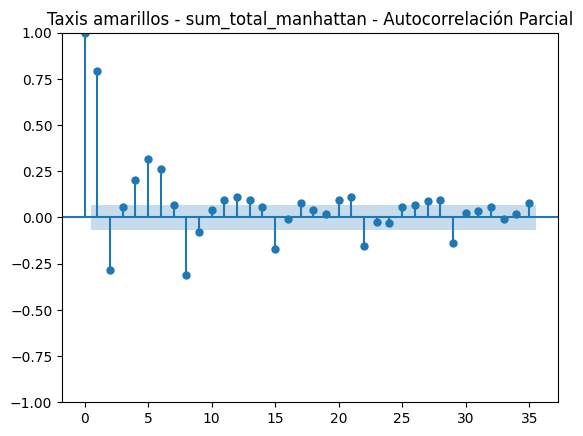

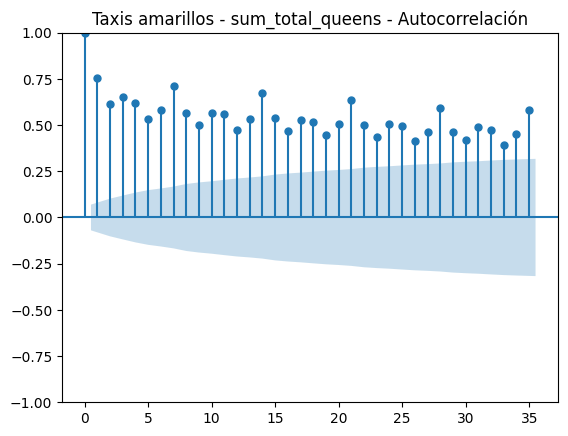

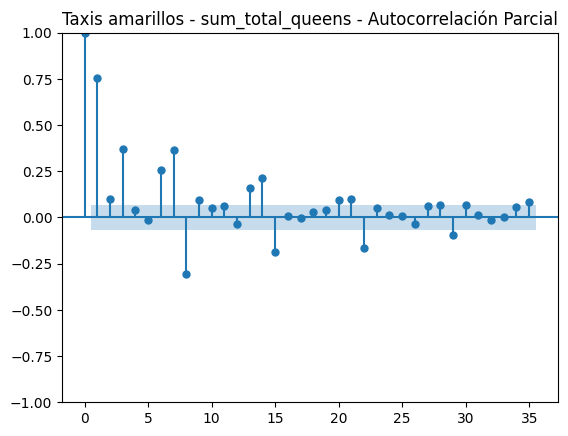

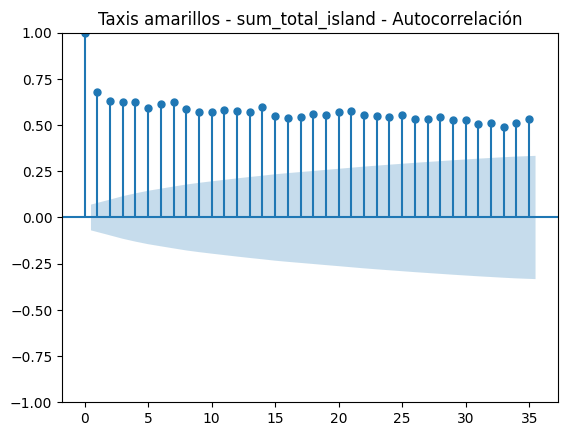

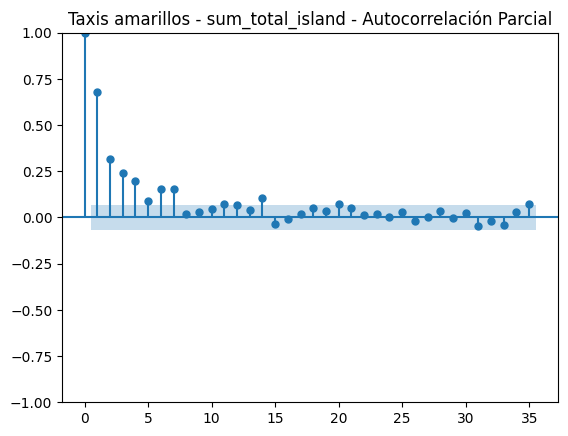

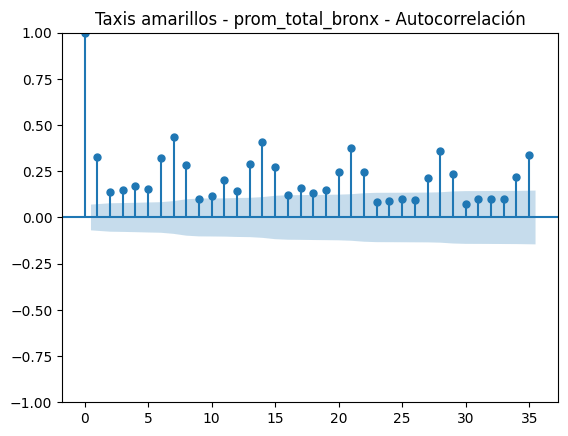

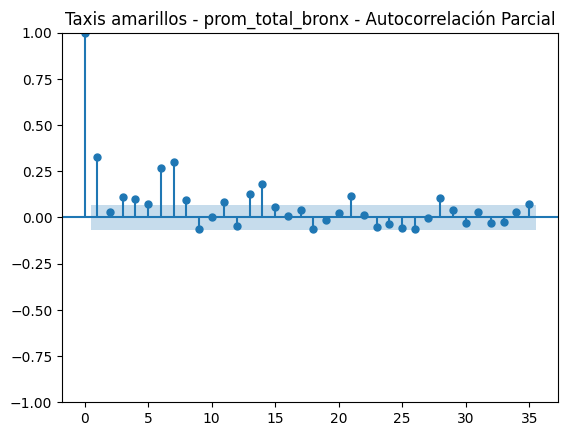

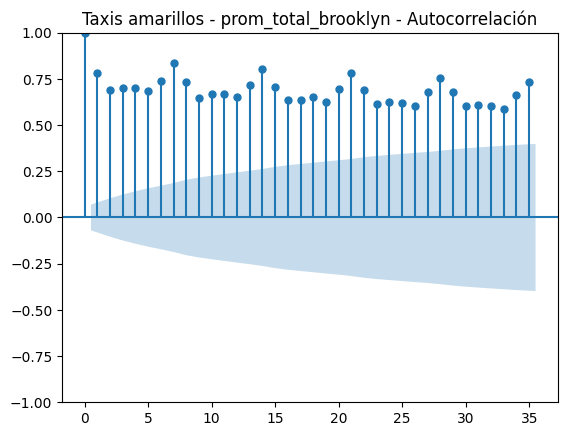

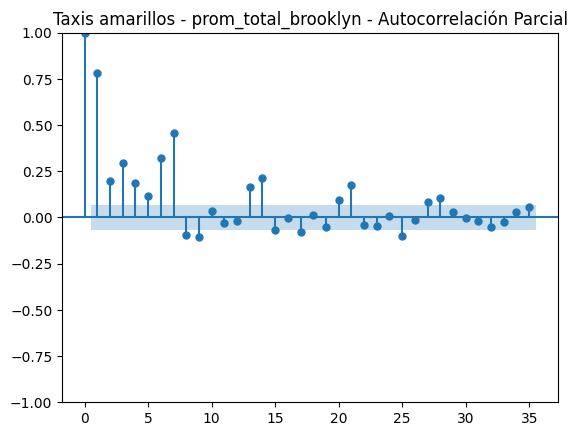

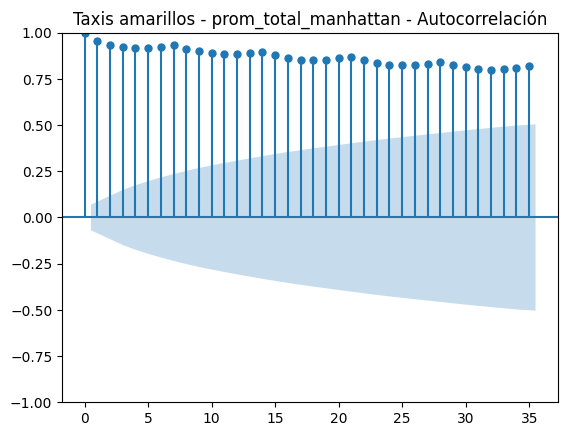

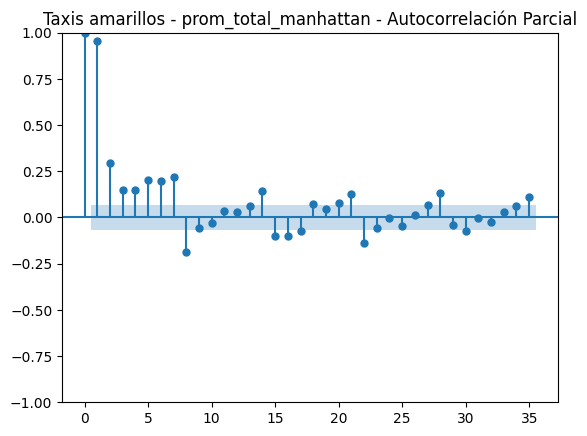

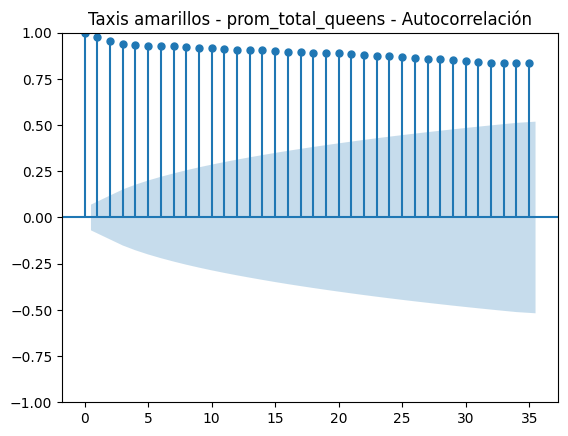

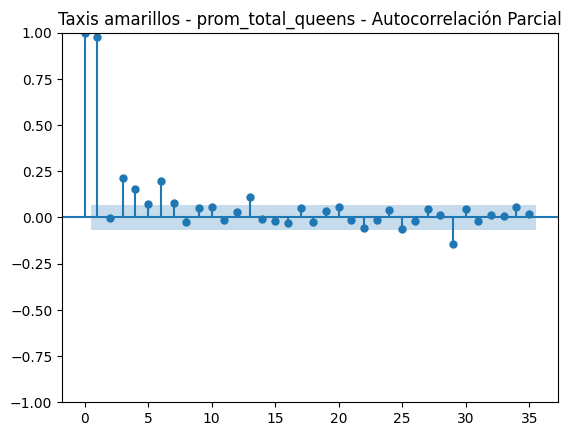

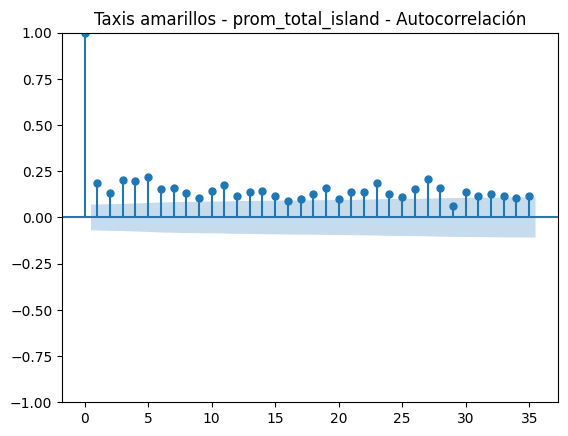

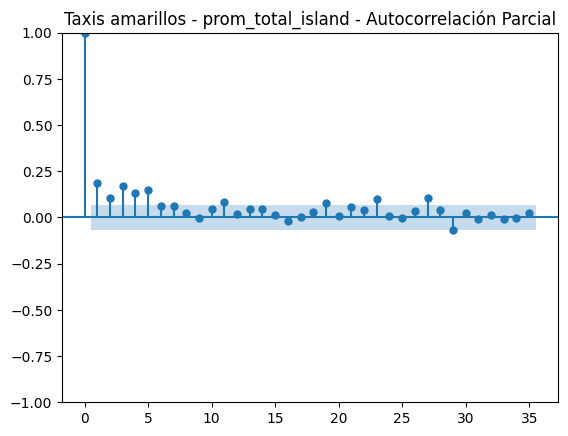

In [12]:
for col in yellow_df_pivot.columns:
    plot_acf(yellow_df_pivot[col], lags=7*5, title=f"Taxis amarillos - {col} - Autocorrelación")
    plot_pacf(yellow_df_pivot[col], lags=7*5, title=f"Taxis amarillos - {col} - Autocorrelación Parcial")

## Entrenamiento del modelo

<p>Como medida del rendimiento del modelo, se utilizará el coeficiente U de Theil (versión 1), que mide el porcentaje de desajuste del modelo respecto a los datos temporales en un rango entre 0 y 1, donde un modelo cercano a 0 da mejores resultados.

In [8]:
def calcular_u1(y_true, y_pred):
    size = len(y_true)
    u = np.sqrt(np.sum(np.square(y_true-y_pred))/size)
    u /= np.sum(np.sqrt(np.sum(np.square(y_true))/size)+np.sqrt(np.sum(np.square(y_pred))/size))
    return u

In [9]:
train_size = len(yellow_df_pivot[yellow_df_pivot.index < date(year=2024, month=1, day=1)])
train_size

730

In [10]:
yellow_df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790 entries, 2022-01-01 to 2024-02-29
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cant_registros_bronx      790 non-null    float64
 1   cant_registros_brooklyn   790 non-null    float64
 2   cant_registros_manhattan  790 non-null    float64
 3   cant_registros_queens     790 non-null    float64
 4   cant_registros_island     790 non-null    float64
 5   sum_distancia_bronx       790 non-null    float64
 6   sum_distancia_brooklyn    790 non-null    float64
 7   sum_distancia_manhattan   790 non-null    float64
 8   sum_distancia_queens      790 non-null    float64
 9   sum_distancia_island      790 non-null    float64
 10  sum_total_bronx           790 non-null    float64
 11  sum_total_brooklyn        790 non-null    float64
 12  sum_total_manhattan       790 non-null    float64
 13  sum_total_queens          790 non-null    float64
 14 

In [11]:
yellow_df_pivot.index = pd.to_datetime(yellow_df_pivot.index)

<p>A continuación se muestra la busqueda en grid, con los parámetros indicados. Los resultados obtenidos son:</p>

- Para cantidad de viajes: 14 lags, 5 estimadores, profundidad máxima de 8.
- Para suma de distancia: 14 lags, 50 estimadores, profundidad máxima de 9.
- Para suma de total: 14 lags, 9 estimadores, profundidad máxima de 12.
- Para promedio de total: 10 lags, 5 estimadores, profundidad máxima de 15.


In [12]:
yellow_forecaster = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=5,
        n_estimators=50,
        random_state=42
    ),
    lags=7,
    transformer_series=StandardScaler()
)

lags_grid = [5, 7, 8, 10, 14, 15]
param_grid = {
    'n_estimators': [5, 10, 20, 50, 100],
    'max_depth': list(range(4, 16))
}

yellow_forecasters = {}
yellow_grids = {}
for col in ["cant_registros", "sum_distancia", "sum_total", "prom_total"]:
    cols = [x for x in list(yellow_df_pivot.columns) if col in x]

    yellow_grid = grid_search_forecaster_multiseries(
        forecaster=yellow_forecaster,
        series=yellow_df_pivot.reset_index(),
        param_grid=param_grid,
        lags_grid=lags_grid,
        levels=cols,
        steps=10,
        metric=calcular_u1,
        initial_train_size=train_size,
        refit=True,
        fixed_train_size=True,
        return_best=True,
        verbose=False,
        show_progress=True
    )
    
    yellow_grids[col] = yellow_grid
    yellow_forecasters[col] = yellow_forecaster

yellow_grids

360 models compared for 5 level(s). Number of iterations: 360.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_depth': 8, 'n_estimators': 5}
  Backtesting metric: 0.1419949186770588
  Levels: ['cant_registros_bronx', 'cant_registros_brooklyn', 'cant_registros_manhattan', 'cant_registros_queens', 'cant_registros_island']

360 models compared for 5 level(s). Number of iterations: 360.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_depth': 9, 'n_estimators': 50}
  Backtesting metric: 0.18235364099610882
  Levels: ['sum_distancia_bronx', 'sum_distancia_brooklyn', 'sum_distancia_manhattan', 'sum_distancia_queens', 'sum_distancia_island']

360 models compared for 5 level(s). Number of iterations: 360.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_depth': 12, 'n_estimators': 5}
  Backtesting metric: 0.15643511305262653
  Levels: ['sum_total_bronx', 'sum_total_brooklyn', 'sum_total_manhattan', 'sum_total_queens', 'sum_total_island']

360 models compared for 5 level(s). Number of iterations: 360.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 15, 'n_estimators': 5}
  Backtesting metric: 0.0838298009659733
  Levels: ['prom_total_bronx', 'prom_total_brooklyn', 'prom_total_manhattan', 'prom_total_queens', 'prom_total_island']



{'cant_registros':                                                 levels  \
 260  [cant_registros_bronx, cant_registros_brooklyn...   
 275  [cant_registros_bronx, cant_registros_brooklyn...   
 255  [cant_registros_bronx, cant_registros_brooklyn...   
 328  [cant_registros_bronx, cant_registros_brooklyn...   
 358  [cant_registros_bronx, cant_registros_brooklyn...   
 ..                                                 ...   
 57   [cant_registros_bronx, cant_registros_brooklyn...   
 51   [cant_registros_bronx, cant_registros_brooklyn...   
 40   [cant_registros_bronx, cant_registros_brooklyn...   
 55   [cant_registros_bronx, cant_registros_brooklyn...   
 50   [cant_registros_bronx, cant_registros_brooklyn...   
 
                                                   lags  \
 260    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
 275    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
 255    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
 328  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10

<p>A continuación se entrenan modelos con los parámetros encontrados, y se realizan las predicciones.

#### Modelo para cantidad de registros

In [12]:
cols = [col for col in yellow_df_pivot.columns if "cant_registros" in col]
yellow_forecaster_cant = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=8,
        n_estimators=5,
        random_state=42
    ),
    lags=14,
    transformer_series=StandardScaler()
)

yellow_metrics, yellow_predictions = backtesting_forecaster_multiseries(
    forecaster=yellow_forecaster_cant,
    series=yellow_df_pivot.reset_index(),
    levels=cols,
    initial_train_size=train_size,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

yellow_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,calcular_u1
0,cant_registros_bronx,3.180861e+03,44.115725,0.126976
1,cant_registros_brooklyn,4.333566e+04,141.162600,0.116886
2,cant_registros_manhattan,8.643543e+07,7048.175811,0.052010
3,cant_registros_queens,1.636138e+06,1001.228611,0.073949
4,cant_registros_island,3.178187e+00,1.438954,0.340153


In [29]:
yellow_forecaster_cant

ForecasterAutoregMultiSeries 
Regressor: RandomForestRegressor(max_depth=8, n_estimators=5, random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: ordinal_category 
Window size: 14 
Series levels (names): None 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: bootstrap: True, ccp_alpha: 0.0, criterion: squared_error, max_depth: 8, max_features: 1.0, ... 
fit_kwargs: {} 
Creation date: 2024-05-22 17:01:14 
Last fit date: None 
Skforecast version: 0.12.1 
Python version: 3.12.1 
Forecaster id: None 

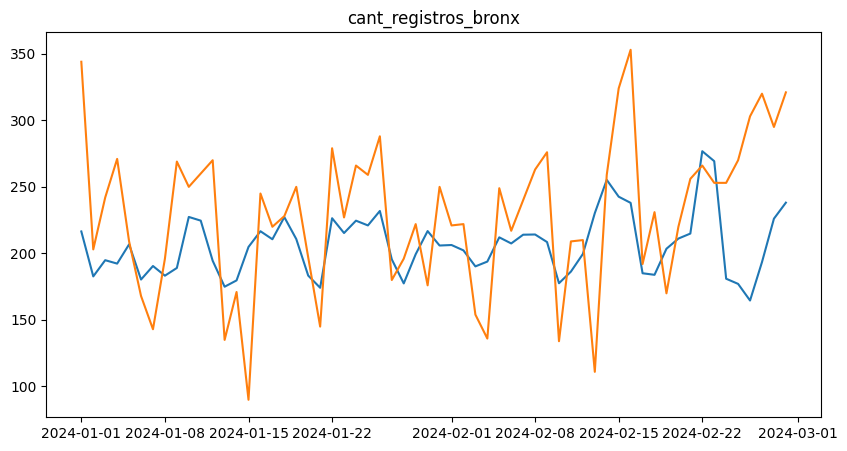

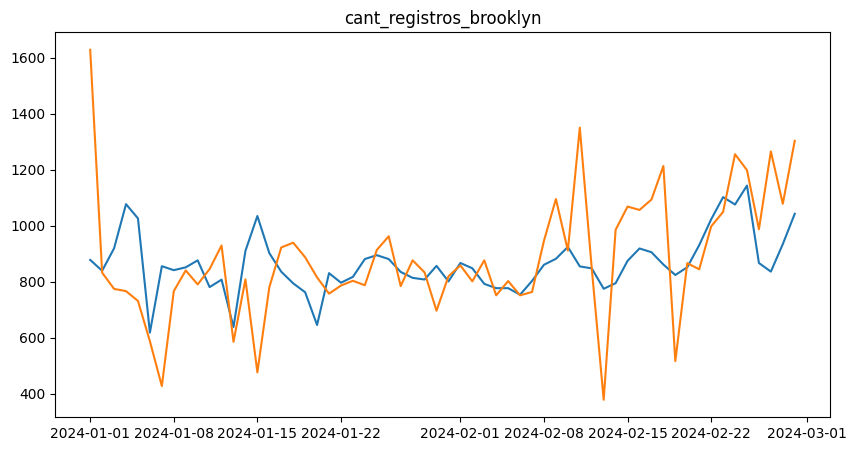

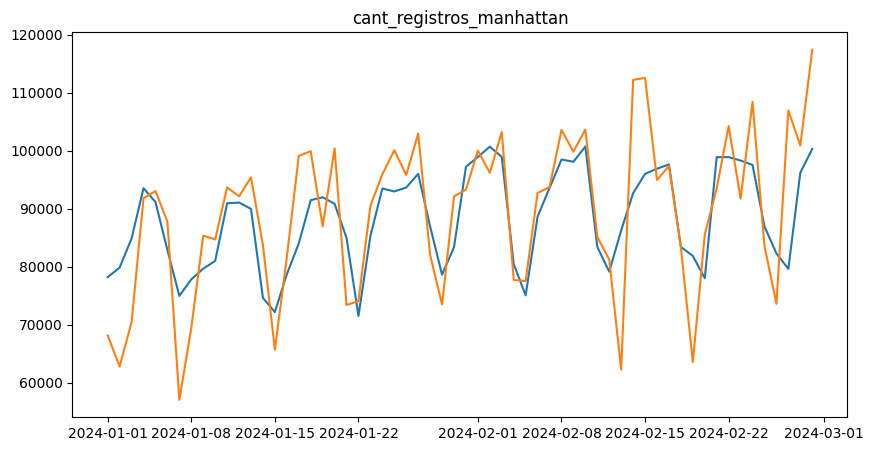

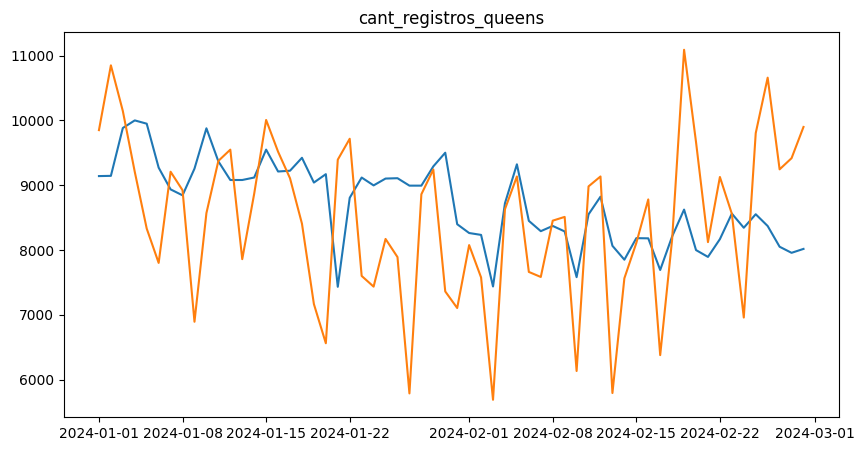

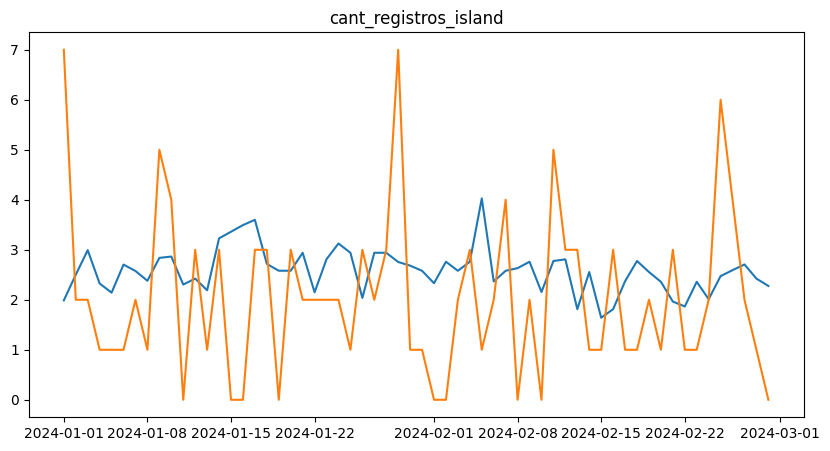

In [13]:
for col in yellow_predictions.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(yellow_df_pivot[train_size:].index, yellow_predictions[col])
    plt.plot(yellow_df_pivot[train_size:].index, yellow_df_pivot[train_size:][col])
    plt.title(col)
    plt.show()

In [92]:
steps = 31
yellow_forecaster_cant.fit(series=yellow_df_pivot[cols])
yellow_preds_mar_cant = yellow_forecaster_cant.predict(steps=steps)
yellow_preds_mar_cant

,cant_registros_bronx,cant_registros_brooklyn,cant_registros_island,cant_registros_manhattan,cant_registros_queens
790,270.275557,1148.785695,1.938566,95491.663359,9324.772244
791,263.028141,1130.748964,2.895839,97691.422592,7649.007217
792,280.148336,1162.063875,3.873160,82803.941382,9618.883340
793,258.138126,1058.402483,3.557479,76065.078289,10305.684122
794,278.847679,933.470812,2.924608,100121.704290,9865.926337
795,268.847679,959.613791,2.220441,100009.494240,9316.531360
796,263.878427,1025.705502,1.882829,103904.255057,9709.519192
797,207.764420,1019.547942,2.739568,98873.022808,9487.642930
798,174.052847,1019.547942,2.895839,101762.218781,7891.802763
799,243.951949,1055.497027,3.807771,82803.941382,9425.291059


In [93]:
with open("yellow_taxis_cant.pkl", "wb") as model:
    pickle.dump(yellow_forecaster_cant, model)

#### Modelo para suma de distancia recorrida

In [16]:
yellow_grids["sum_distancia"]

,levels,lags,lags_label,params,calcular_u1,max_depth,n_estimators
268,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 9, 'n_estimators': 50}",0.182354,9,50
282,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 12, 'n_estimators': 20}",0.182775,12,20
278,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 11, 'n_estimators': 50}",0.183431,11,50
267,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 9, 'n_estimators': 20}",0.183746,9,20
262,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 8, 'n_estimators': 20}",0.183819,8,20
...,...,...,...,...,...,...,...
46,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 13, 'n_estimators': 10}",0.236394,13,10
50,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 14, 'n_estimators': 5}",0.239440,14,5
45,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 13, 'n_estimators': 5}",0.240277,13,5
55,"[sum_distancia_bronx, sum_distancia_brooklyn, ...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 15, 'n_estimators': 5}",0.249101,15,5


In [94]:
yellow_forecaster_dist = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=9,
        n_estimators=50,
        random_state=42
    ),
    lags=14,
    transformer_series=StandardScaler()
)

cols = [col for col in yellow_df_pivot.columns if "sum_distancia" in col]
yellow_metrics, yellow_predictions = backtesting_forecaster_multiseries(
    forecaster=yellow_forecaster_dist,
    series=yellow_df_pivot.reset_index(),
    levels=cols,
    initial_train_size=train_size,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

yellow_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,calcular_u1
0,sum_distancia_bronx,3.204398e+05,487.147088,0.207300
1,sum_distancia_brooklyn,1.332167e+06,856.596704,0.124391
2,sum_distancia_manhattan,4.059361e+08,16172.858842,0.049653
3,sum_distancia_queens,2.219113e+08,11800.907231,0.072271
4,sum_distancia_island,3.250653e+02,14.400931,0.458153


In [62]:
yellow_predictions

,sum_distancia_bronx,sum_distancia_brooklyn,sum_distancia_manhattan,sum_distancia_queens,sum_distancia_island
730,1136.557898,4255.645312,186024.181893,103755.090146,20.340063
731,866.128530,4207.827867,185961.036258,110930.327489,16.931199
732,1142.697612,4762.152936,202516.683795,123091.124838,20.051680
733,1232.697429,4991.230432,218502.308279,122521.188756,19.968875
734,1076.074097,4954.120126,222043.783530,121619.848297,18.427652
735,616.168731,3396.605405,188291.899768,116270.949241,17.531950
736,934.755762,3977.226722,177916.800865,109300.857593,21.648296
737,946.455223,4155.474302,188213.918291,103720.223987,21.692089
738,923.710775,4347.726034,190788.101168,111627.831774,18.628562
739,986.593312,4629.387971,194706.306562,117903.492668,20.592236


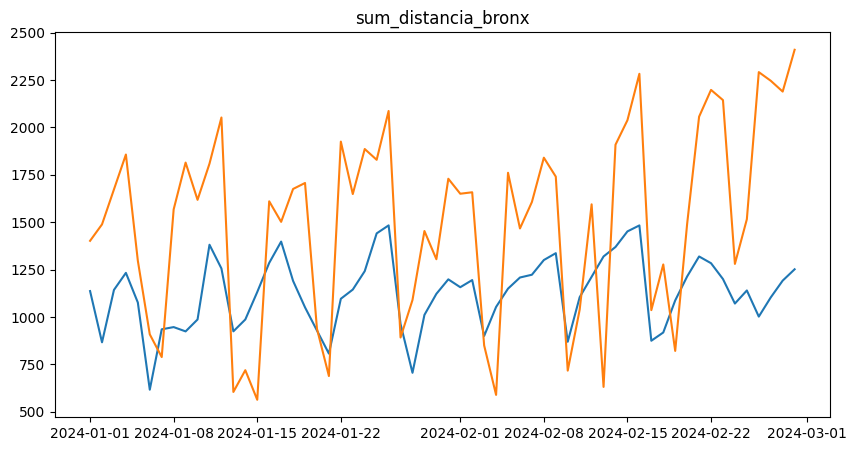

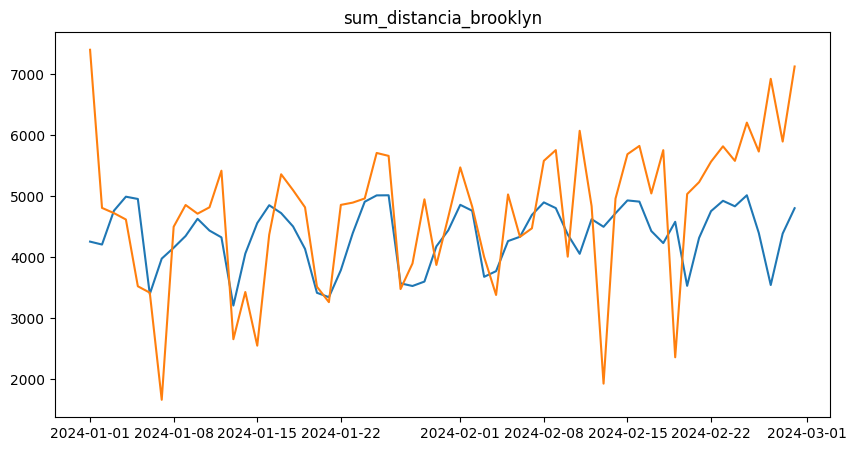

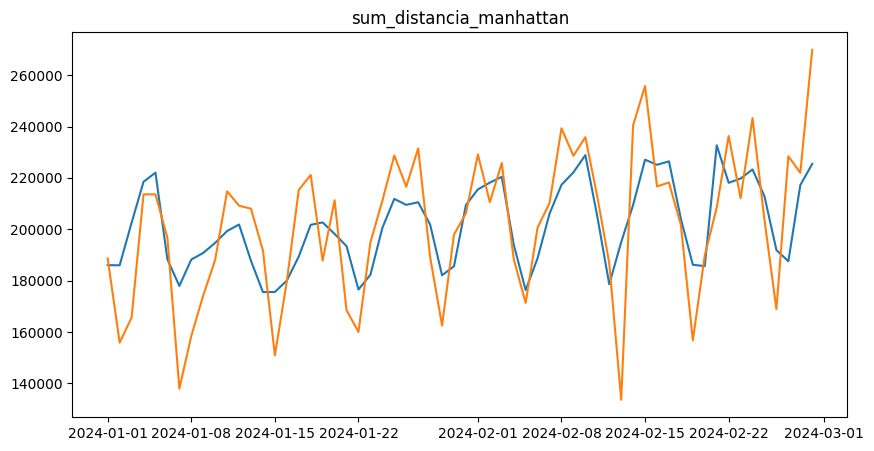

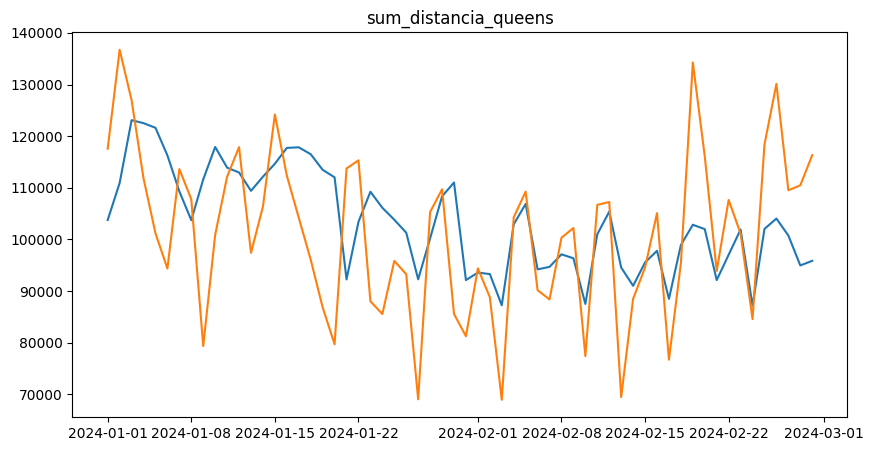

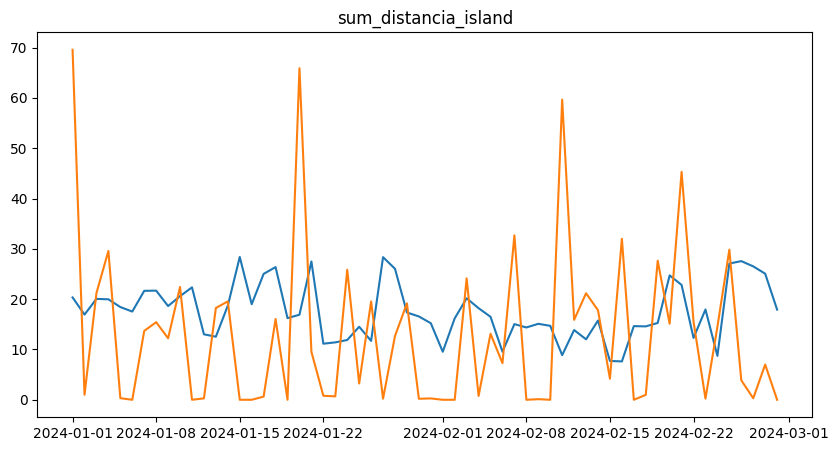

In [70]:
for col in yellow_predictions.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(yellow_df_pivot[train_size:].index, yellow_predictions[col])
    plt.plot(yellow_df_pivot[train_size:].index, yellow_df_pivot[train_size:][col])
    plt.title(col)
    plt.show()

In [95]:
yellow_forecaster_dist.fit(series=yellow_df_pivot[cols])
yellow_preds_mar_dist = yellow_forecaster_dist.predict(steps=steps)
yellow_preds_mar_dist

,sum_distancia_bronx,sum_distancia_brooklyn,sum_distancia_island,sum_distancia_manhattan,sum_distancia_queens
790,2110.237753,6001.235826,10.998332,227914.942311,105178.118650
791,1829.772099,5725.288031,12.709298,235007.558566,91679.120791
792,1688.516985,5465.567389,15.580682,211290.652426,111891.422821
793,1464.578882,5407.210112,15.073886,186096.037475,116823.275429
794,1566.649599,5661.700719,13.959371,209848.831586,113383.856103
795,1509.381167,5858.729097,15.297350,223140.635626,108343.996370
796,1741.290880,5753.188749,12.107338,225717.841027,111424.133015
797,1633.303334,5718.716533,14.290840,226029.985838,106544.623625
798,1486.149846,5590.194847,15.360542,228615.441118,95125.650214
799,1563.255000,5689.291161,15.467837,214101.984231,107385.230242


In [100]:
with open("yellow_taxis_dist.pkl", "wb") as model:
    pickle.dump(yellow_forecaster_dist, model)

#### Modelo para suma de costo total

In [18]:
yellow_grids["sum_total"]

,levels,lags,lags_label,params,calcular_u1,max_depth,n_estimators
280,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 12, 'n_estimators': 5}",0.156435,12,5
267,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 9, 'n_estimators': 20}",0.157584,9,20
271,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 10}",0.158150,10,10
277,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 11, 'n_estimators': 20}",0.158654,11,20
272,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 20}",0.158818,10,20
...,...,...,...,...,...,...,...
1,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 4, 'n_estimators': 10}",0.191471,4,10
52,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 14, 'n_estimators': 20}",0.191645,14,20
59,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 15, 'n_estimators': 100}",0.192035,15,100
54,"[sum_total_bronx, sum_total_brooklyn, sum_tota...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 14, 'n_estimators': 100}",0.192058,14,100


In [97]:
yellow_forecaster_total = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=12,
        n_estimators=5,
        random_state=42
    ),
    lags=14,
    transformer_series=StandardScaler()
)

cols = [col for col in yellow_df_pivot.columns if "sum_total" in col]
yellow_metrics, yellow_predictions = backtesting_forecaster_multiseries(
    forecaster=yellow_forecaster_total,
    series=yellow_df_pivot.reset_index(),
    levels=cols,
    initial_train_size=train_size,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

yellow_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,calcular_u1
0,sum_total_bronx,5.871812e+06,2101.826917,0.158240
1,sum_total_brooklyn,4.955358e+07,4646.213203,0.121907
2,sum_total_manhattan,6.576462e+10,184982.914929,0.062915
3,sum_total_queens,6.911799e+09,66468.536130,0.070742
4,sum_total_island,1.156818e+04,85.708487,0.368372


In [35]:
yellow_predictions

,sum_distancia_bronx,sum_distancia_brooklyn,sum_distancia_manhattan,sum_distancia_queens,sum_distancia_island
730,1136.557898,4255.645312,186024.181893,103755.090146,20.340063
731,866.128530,4207.827867,185961.036258,110930.327489,16.931199
732,1142.697612,4762.152936,202516.683795,123091.124838,20.051680
733,1232.697429,4991.230432,218502.308279,122521.188756,19.968875
734,1076.074097,4954.120126,222043.783530,121619.848297,18.427652
735,616.168731,3396.605405,188291.899768,116270.949241,17.531950
736,934.755762,3977.226722,177916.800865,109300.857593,21.648296
737,946.455223,4155.474302,188213.918291,103720.223987,21.692089
738,923.710775,4347.726034,190788.101168,111627.831774,18.628562
739,986.593312,4629.387971,194706.306562,117903.492668,20.592236


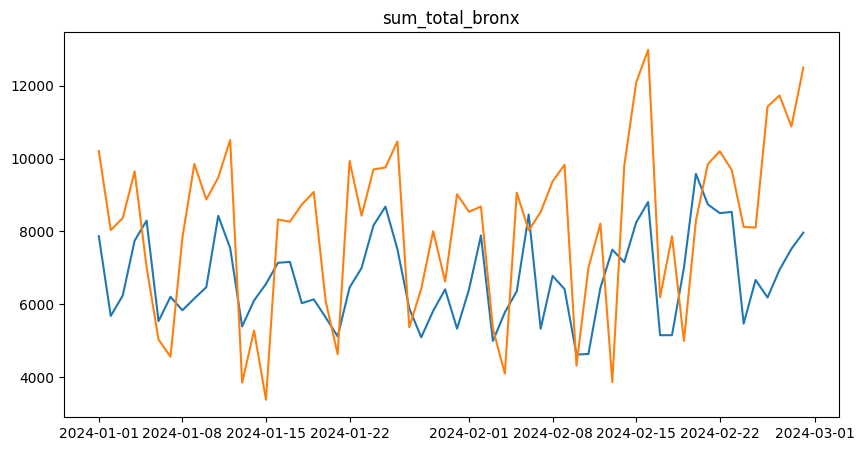

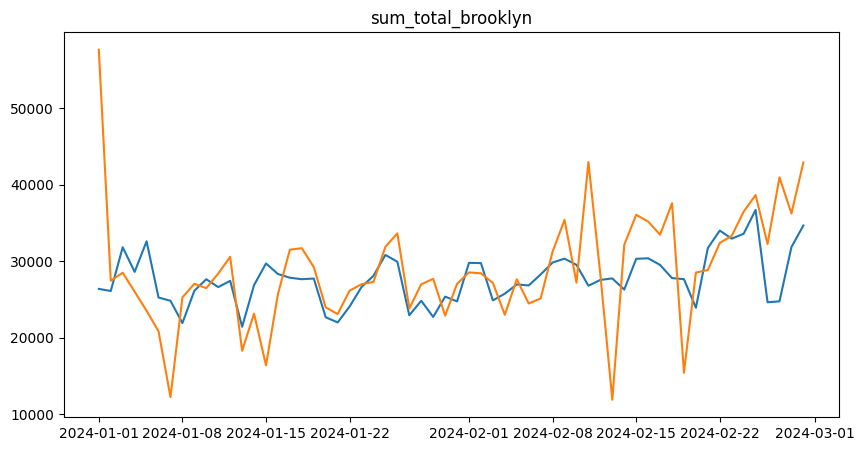

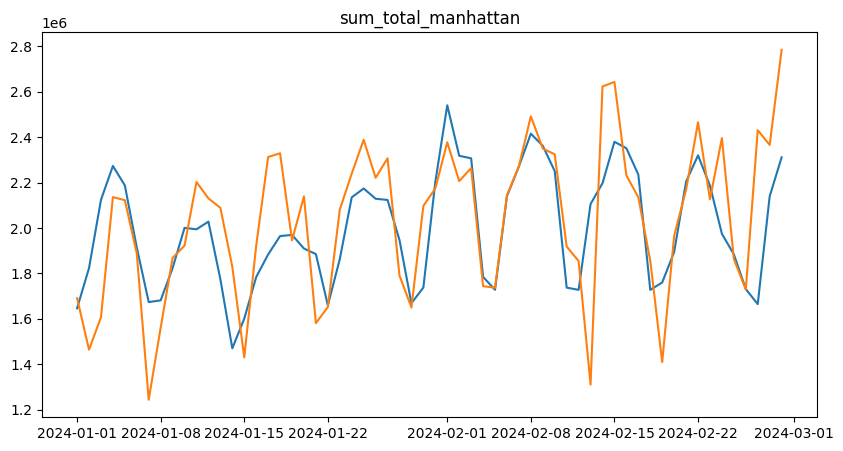

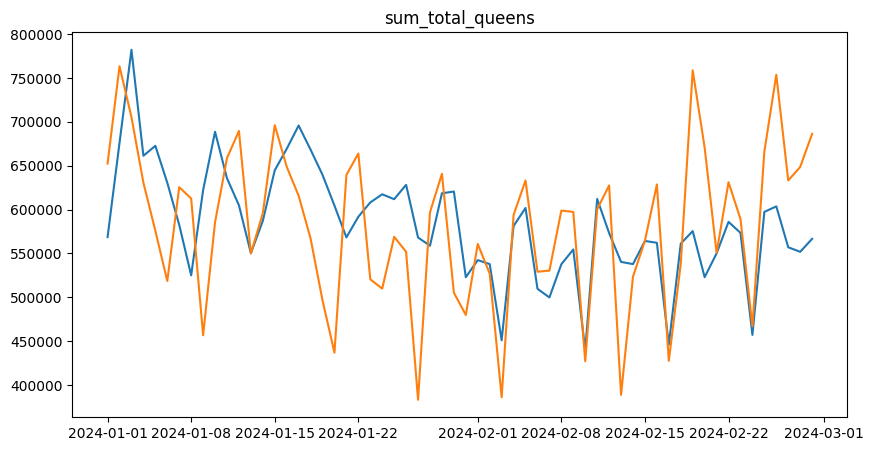

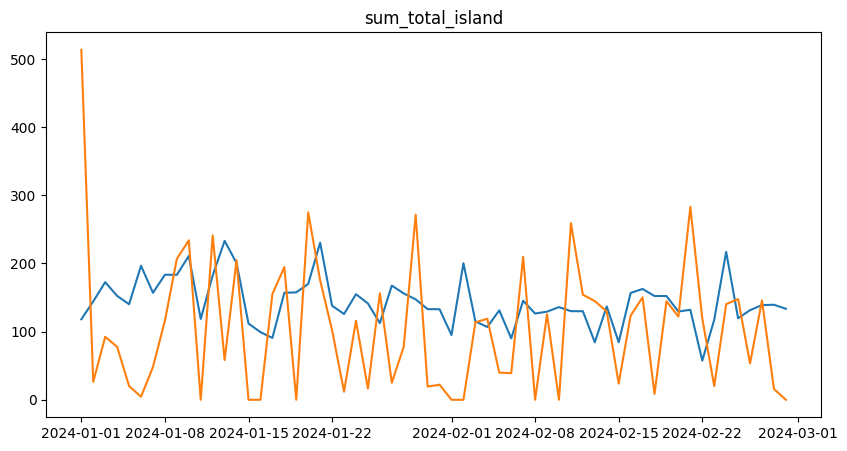

In [72]:
for col in yellow_predictions.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(yellow_df_pivot[train_size:].index, yellow_predictions[col])
    plt.plot(yellow_df_pivot[train_size:].index, yellow_df_pivot[train_size:][col])
    plt.title(col)
    plt.show()

In [98]:
yellow_forecaster_total.fit(series=yellow_df_pivot[cols])
yellow_preds_mar_total = yellow_forecaster_total.predict(steps=steps)
yellow_preds_mar_total

,sum_total_bronx,sum_total_brooklyn,sum_total_island,sum_total_manhattan,sum_total_queens
790,9989.486275,39989.784533,100.116027,2.266823e+06,632173.488873
791,9173.470210,38668.651856,136.369339,2.259415e+06,510166.803524
792,6541.953591,38058.125971,119.544183,1.886906e+06,657759.342461
793,7087.325686,30788.582437,176.209845,1.531909e+06,711438.030252
794,6399.937451,30221.242947,117.050542,1.895724e+06,638379.949400
795,6741.280969,28242.455189,147.163205,2.165907e+06,632731.525277
796,8641.925062,33012.027170,81.848525,2.420882e+06,646871.095143
797,6352.593731,34670.931993,160.262912,2.140365e+06,627280.270401
798,8049.194948,33664.849095,113.038539,2.296375e+06,561103.504859
799,7117.400704,34233.491956,143.924372,1.909462e+06,680643.887800


In [99]:
with open("yellow_taxis_total.pkl", "wb") as model:
    pickle.dump(yellow_forecaster_total, model)

#### Modelo para promedio del costo total

In [20]:
yellow_grids["prom_total"]

,levels,lags,lags_label,params,calcular_u1,max_depth,n_estimators
235,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 5}",0.083830,15,5
219,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 11, 'n_estimators': 100}",0.084595,11,100
202,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 20}",0.084782,8,20
104,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 12, 'n_estimators': 100}",0.084867,12,100
214,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.084998,10,100
...,...,...,...,...,...,...,...
30,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 5}",0.095887,10,5
290,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 14, 'n_estimators': 5}",0.095892,14,5
270,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 5}",0.096144,10,5
45,"[prom_total_bronx, prom_total_brooklyn, prom_t...","[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 13, 'n_estimators': 5}",0.096749,13,5


In [104]:
yellow_forecaster_prom = ForecasterAutoregMultiSeries(
    regressor=RandomForestRegressor(
        max_depth=15,
        n_estimators=5,
        random_state=42
    ),
    lags=10,
    transformer_series=StandardScaler()
)

cols = [col for col in yellow_df_pivot.columns if "prom_total" in col]
yellow_metrics, yellow_predictions = backtesting_forecaster_multiseries(
    forecaster=yellow_forecaster_prom,
    series=yellow_df_pivot.reset_index(),
    levels=cols,
    initial_train_size=train_size,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

yellow_metrics

  0%|          | 0/6 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,calcular_u1
0,prom_total_bronx,9.435969,2.465452,0.043912
1,prom_total_brooklyn,3.435602,1.433548,0.028490
2,prom_total_manhattan,0.733343,0.663907,0.018676
3,prom_total_queens,2.260942,1.225138,0.010961
4,prom_total_island,1321.475412,29.925539,0.317110


In [105]:
yellow_predictions

,prom_total_bronx,prom_total_brooklyn,prom_total_manhattan,prom_total_queens,prom_total_island
730,33.648038,30.859787,23.105817,65.110424,66.510590
731,36.441397,30.244398,23.942479,68.724234,61.156537
732,36.907593,30.387868,24.092516,69.701781,62.906423
733,36.525540,31.065292,24.092979,69.723468,61.759881
734,35.642384,31.451139,24.179635,69.723468,51.156722
735,32.389749,32.338961,23.752484,69.626999,62.364117
736,33.802380,31.979898,22.657661,67.112858,68.347111
737,32.306706,31.393605,22.873283,66.830988,68.173179
738,33.810961,31.880446,23.942479,68.864303,67.772489
739,35.452835,31.235614,24.021855,69.701781,62.812135


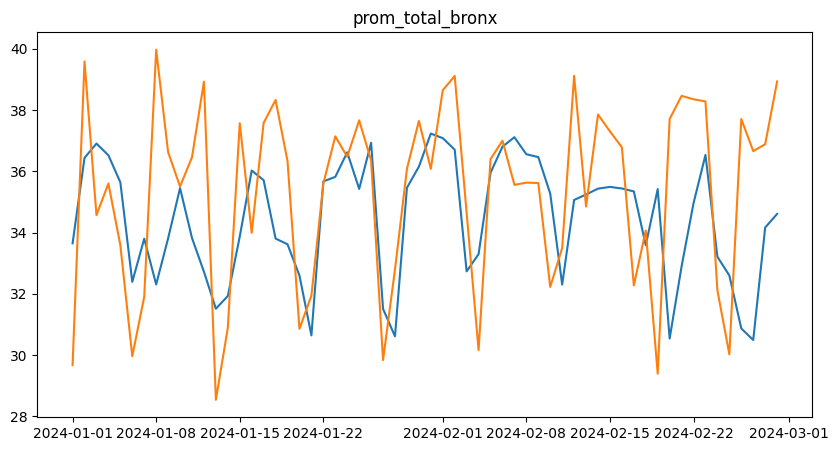

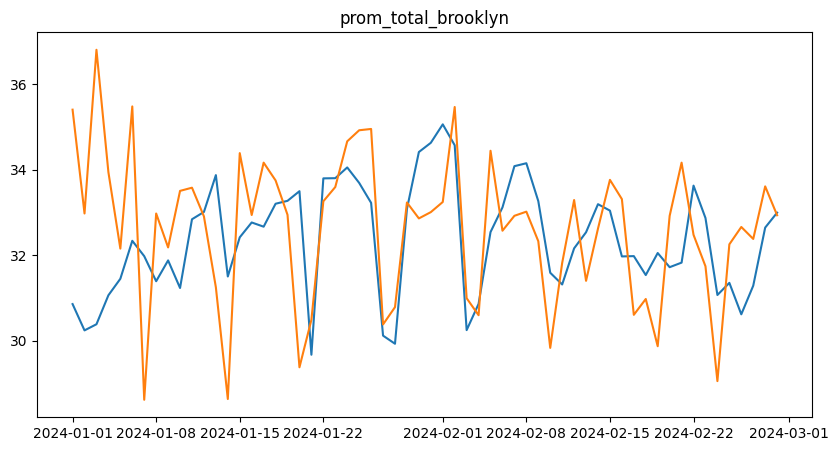

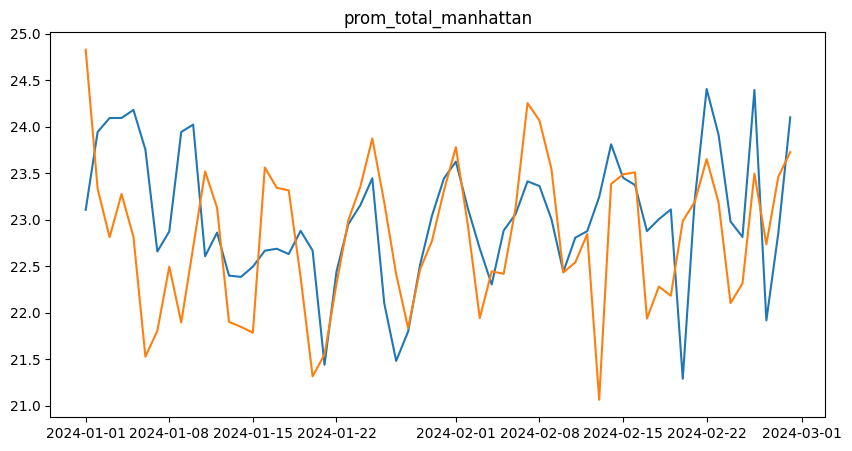

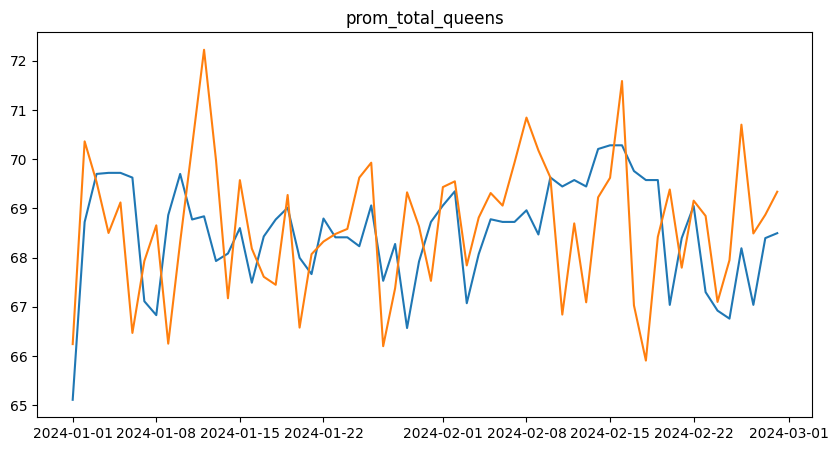

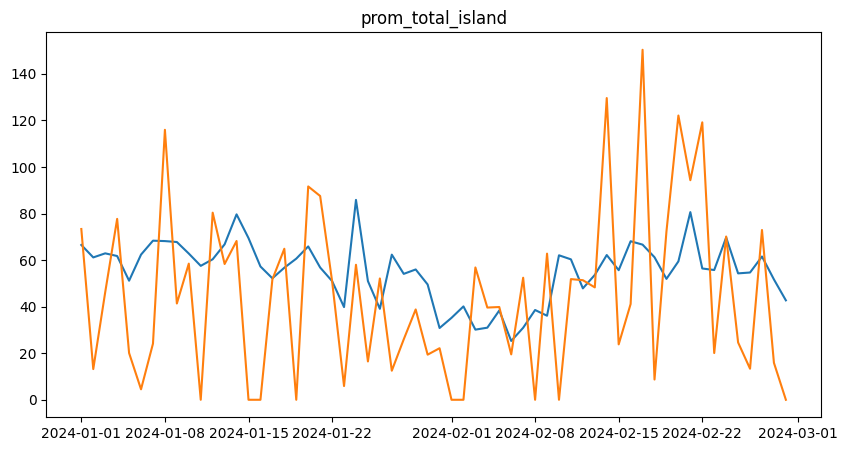

In [106]:
for col in yellow_predictions.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(yellow_df_pivot[train_size:].index, yellow_predictions[col])
    plt.plot(yellow_df_pivot[train_size:].index, yellow_df_pivot[train_size:][col])
    plt.title(col)
    plt.show()

In [107]:
yellow_forecaster_prom.fit(series=yellow_df_pivot[cols])
yellow_preds_mar_prom = yellow_forecaster_prom.predict(steps=steps)
yellow_preds_mar_prom

,prom_total_bronx,prom_total_brooklyn,prom_total_island,prom_total_manhattan,prom_total_queens
790,37.932790,31.477943,48.917163,22.914606,69.639232
791,30.691330,31.510036,46.304825,22.837446,68.859267
792,34.478696,32.032747,33.685049,21.211425,68.815495
793,36.505176,32.148770,18.559641,22.803953,69.154786
794,35.205866,32.396007,43.954016,22.966918,69.063500
795,37.187164,32.931135,35.001364,23.439704,69.639232
796,37.018465,32.553526,48.352138,23.713053,69.857514
797,36.708044,31.725834,44.025212,23.358669,69.857514
798,34.795093,31.292010,48.204960,23.076116,69.639232
799,36.446774,30.069253,34.417308,21.955959,69.351321


In [108]:
with open("yellow_taxis_prom.pkl", "wb") as model:
    pickle.dump(yellow_forecaster_prom, model)

# Resumen para el mes de marzo

<p>Para el resumen del mes, se utilizan las predicciones generadas por todos los modelos, agregándolas según corresponda, luego se guardan como un dataframe y se exportan a CSV.

In [109]:
barrios = ["Bronx", "Brooklyn", "Staten Island", "Manhattan", "Queens"]
cants = yellow_preds_mar_cant.sum().round().astype(int)
cants.index = barrios
cants.name = "cant_registros"
cants

Bronx               7261
Brooklyn           33042
Staten Island        114
Manhattan        2915916
Queens            295205
Name: cant_registros, dtype: int32

In [110]:
dists = yellow_preds_mar_dist.sum()
dists.index = barrios
dists.name = "sum_distancia"
dists

Bronx            4.878228e+04
Brooklyn         1.769728e+05
Staten Island    4.420455e+02
Manhattan        6.794141e+06
Queens           3.377051e+06
Name: sum_distancia, dtype: float64

In [111]:
totals = yellow_preds_mar_total.sum()
totals.index = barrios
totals.name = "sum_total"
totals

Bronx            2.414579e+05
Brooklyn         1.060234e+06
Staten Island    4.398177e+03
Manhattan        6.652851e+07
Queens           2.000620e+07
Name: sum_total, dtype: float64

In [112]:
proms = yellow_preds_mar_prom.mean()
proms.index = barrios
proms.name = "prom_total"
proms

Bronx            35.468696
Brooklyn         32.086208
Staten Island    42.993903
Manhattan        22.953074
Queens           69.747059
Name: prom_total, dtype: float64

In [113]:
marzo = pd.DataFrame([cants, dists, totals, proms]).transpose()
marzo.index.name = "barrio_abordaje"
marzo.reset_index(inplace=True)
marzo["mes"] = date(year=2024, month=3, day=1)
marzo

,barrio_abordaje,cant_registros,sum_distancia,sum_total,prom_total,mes
0,Bronx,7261.0,4.878228e+04,2.414579e+05,35.468696,2024-03-01
1,Brooklyn,33042.0,1.769728e+05,1.060234e+06,32.086208,2024-03-01
2,Staten Island,114.0,4.420455e+02,4.398177e+03,42.993903,2024-03-01
3,Manhattan,2915916.0,6.794141e+06,6.652851e+07,22.953074,2024-03-01
4,Queens,295205.0,3.377051e+06,2.000620e+07,69.747059,2024-03-01


In [114]:
marzo.to_csv("predicciones_marzo_yellow.csv", index=False)